# Imports

In [4]:
import hoomd

In [22]:
import numpy
device = hoomd.device.CPU()
seed = numpy.random.randint(1,1e4)
simulation = hoomd.Simulation(device = device, seed = seed)
import matplotlib.pyplot as plt

# Autocorrelation

In [6]:
def autocorr1D(array):
    """Takes in a linear np array, performs autocorrelation
    function and returns normalized array with half the length
    of the input.

    Parameters
    ----------
    data : numpy.typing.Arraylike, required
        1-D series of data to perform autocorrelation on.

    Returns
    -------
    1D np.array

    """
    ft = numpy.fft.rfft(array - numpy.average(array))
    acorr = numpy.fft.irfft(ft * numpy.conjugate(ft)) / (len(array) * numpy.var(array))
    return acorr[0 : len(acorr) // 2]  # noqa: E203

# Heat Capacity

In [106]:
def heat_capacity(energies,temp):
    mean_energy = numpy.mean(energies)
    mean_energy_squared = numpy.mean(numpy.array(energies)**2)
    k_B = 1.0
    E_var = numpy.var(energies)
    C_V_error = numpy.sqrt(E_var / len(energies)) / (k_B * numpy.mean(temp)**2)
    C_V = (mean_energy_squared - mean_energy**2) / (temp**2 * k_B)
    return C_V, C_V_error

# RDF

In [43]:
def rdf(positions, density, r_max=3.0, bin_width=0.02):
    
    N = len(positions)
    volume = N/density
    Lx, Ly, Lz = volume**(1/3),volume**(1/3),volume**(1/3)
    
    num_bins = int(r_max / bin_width)
    rdf_hist = numpy.zeros(num_bins)

    # Loop through all unique particle pairs
    for i in range(N):
        for j in range(i + 1, N):
            dr = positions[i] - positions[j]

            # Apply minimum image convention
            dr[0] -= Lx * numpy.round(dr[0] / Lx)
            dr[1] -= Ly * numpy.round(dr[1] / Ly)
            dr[2] -= Lz * numpy.round(dr[2] / Lz)

            r = numpy.linalg.norm(dr)
            if r < r_max:
                bin_index = int(r / bin_width)
                rdf_hist[bin_index] += 2  # (i,j) and (j,i)

    # Normalize RDF
    r = numpy.linspace(0.5 * bin_width, r_max - 0.5 * bin_width, num_bins)
    shell_volumes = (4/3) * numpy.pi * ((r + 0.5 * bin_width)**3 - (r - 0.5 * bin_width)**3)
    ideal_counts = density * shell_volumes * N
    g_r = rdf_hist / ideal_counts

    return r, g_r

In [11]:
epsilon = 1.0
sigma = 1.0

# Inital Configurations

In [58]:
import freud
starting_density = 0.5
#a is the spacing between particles
a = 1/(starting_density**(1/3.0))
#We want a number of particles N in our system.
#Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
num_replicas = 1
N_particles = num_replicas**3
grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
box_length = grid_particles[0].Lx
print(box_length)

34.01786804199219


In [59]:
import gsd.hoomd
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = grid_particles[1]
frame.configuration.box = [box_length,box_length,box_length,0,0,0]

#Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
#in a coarse-grained simulation we can give them a simple name like A
frame.particles.typeid = [0]*N_particles
frame.particles.types = ['A']

#Finally, save our initial state:
with gsd.hoomd.open(name='initial_state_10.gsd', mode='w') as f:
    f.append(frame)

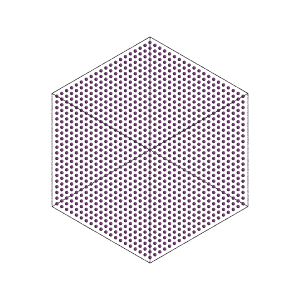

In [7]:
from cmeutils.visualize import FresnelGSD

sim_visualizer = FresnelGSD(
    gsd_file="initial_state.gsd", frame=0, view_axis=(1, 1, 1)
)
sim_visualizer.view()

# Temperature Simulations

In [169]:
dt = 0.005
epsilon = 1.0
T = [0.5,0.7,0.9,1.0,1.25,1.5,1.75,2.0]
pe_temp_runs = {}
ke_temp_runs = {}
positions = {}
for i in T:
  del simulation
  print(i)
  pe_temp_runs[f"{i}"] = []
  ke_temp_runs[f"{i}"] = []
  positions[f"{i}"] = []
  seed = numpy.random.randint(1,1e4)
  simulation = hoomd.Simulation(device = device, seed = seed)
  simulation.create_state_from_gsd(filename='initial_state_12.gsd')
  integrator = hoomd.md.Integrator(dt = dt)
  nvt = hoomd.md.methods.NVT(filter = hoomd.filter.All(),kT=i,tau=100*dt)
  integrator.methods.append(nvt)
  cell = hoomd.md.nlist.Cell(buffer=0.4)

  #Define the force for different particles
  lj = hoomd.md.pair.LJ(nlist=cell)

  lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

  lj.r_cut[('A', 'A')] = 2.5*sigma
  integrator.forces.append(lj)
  simulation.operations.integrator = integrator
  simulation.run(10)

  simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=i)
  thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
      filter=hoomd.filter.All()
  )

  simulation.operations.computes.append(thermodynamic_properties)
  logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
  logger.add(simulation)
  logger.add(thermodynamic_properties,quantities=['potential_energy','kinetic_energy','kinetic_temperature','pressure','volume'])
  gsd_writer = hoomd.write.GSD(filename='projectdata/log_T_'+str(i)+'_N_10_reruns.gsd',
                             trigger=hoomd.trigger.Periodic(1000),
                             mode='xb')
  simulation.operations.writers.append(gsd_writer)
  gsd_writer.log = logger
  tps_tracking = hoomd.logging.Logger(categories=['scalar', 'string'])
  tps_tracking.add(simulation, quantities=['timestep', 'tps'])
  table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e4)), logger=tps_tracking)
  simulation.operations.writers.append(table)
  for step in range(10000):
    simulation.run(10)
    pe_temp_runs[f"{i}"].append(thermodynamic_properties.potential_energy)
    ke_temp_runs[f"{i}"].append(thermodynamic_properties.kinetic_energy)
  ind_samples = 0
  total_steps = 10000
  print(len(pe_temp_runs[f"{i}"]))
  while ind_samples < 20:
      a = autocorr1D(pe_temp_runs[f"{i}"][1000:])
      decorrelation_time = numpy.where(a <= 0)[0][0]
      ind_samples = (total_steps)/decorrelation_time
      print("independent samples: ", ind_samples)
      if ind_samples >= 20:
          break
      for step in range(10000):
        simulation.run(10)
        pe_temp_runs[f"{i}"].append(thermodynamic_properties.potential_energy)
        ke_temp_runs[f"{i}"].append(thermodynamic_properties.kinetic_energy)
      total_steps += 10000
      print(total_steps)
  snapshot = simulation.state.get_snapshot()
  positions[f"{i}"].append(snapshot.particles.position)

0.5
Simulation.timestep  Simulation.tps 
       10000           861.24402    
       20000           1625.42893   
       30000           1537.41032   
       40000           1513.36808   
       50000           1500.75038   
       60000           842.85447    
       70000           1573.70170   
       80000           838.53536    
       90000           1541.09589   
      100000           1566.30700   
10000
independent samples:  5.7405281285878305
      110000           1563.04272   
      120000           840.96431    
      130000           1565.21739   
      140000           1517.19488   
      150000           861.40888    
      160000           1502.50417   
      170000           848.17642    
      180000           1584.78605   
      190000           1563.85752   
      200000           1534.78854   
20000
independent samples:  8.557980316645272
      210000           1513.36808   
      220000           844.91175    
      230000           839.08260    
      240000   

In [75]:
import gsd.hoomd
traj = gsd.hoomd.open('projectdata/log_T_0.5_N_10.gsd', 'r')
traj.log['Simulation/timestep'][0]

AttributeError: 'HOOMDTrajectory' object has no attribute 'log'

In [48]:
print(len(positions[f"0.5"]))

1


0.5
0.7
0.9
1.0
1.25
1.5
1.75
2.0


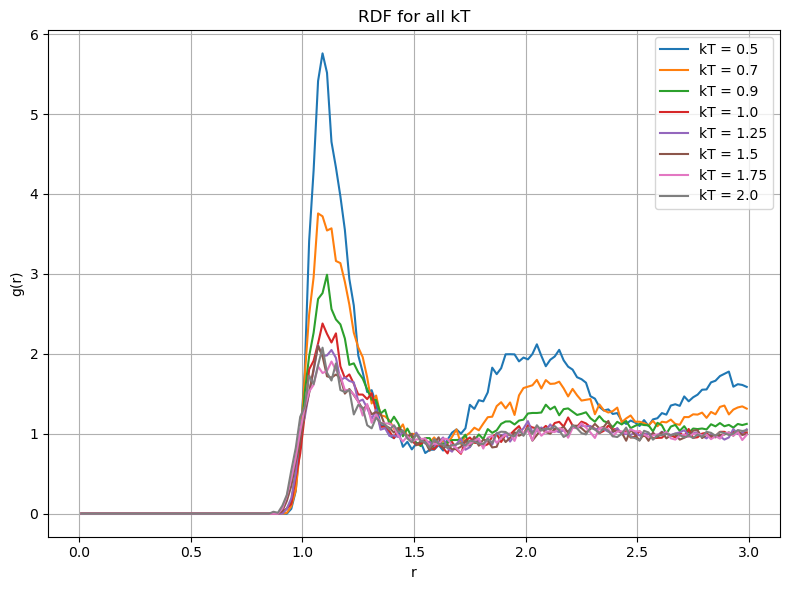

In [171]:
plt.figure(figsize=(8, 6))
T = [0.5,0.7,0.9,1.0,1.25,1.5,1.75,2.0]
for kT in T:
    print(kT)
    snapshot = positions[f"{kT}"]
    r, g_r = rdf(snapshot[0], density=0.5)
    plt.plot(r,g_r, label=f"kT = {kT}")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.title("RDF for all kT")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

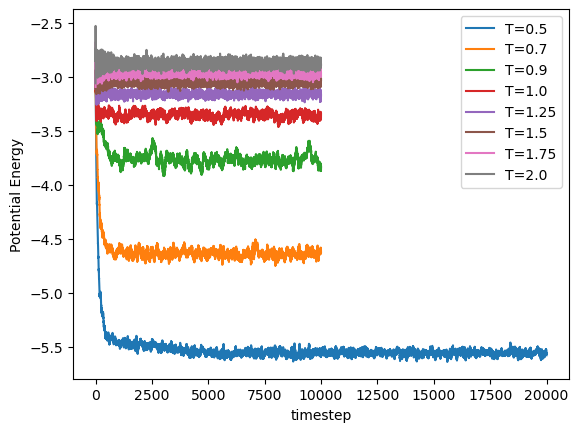

In [179]:
import matplotlib.pyplot as plt
for T, e in pe_temp_runs.items():
  plt.plot(numpy.array(e[:20000])/1728, label=f'T={T}')
plt.xlabel('timestep')
plt.ylabel('Potential Energy')
plt.legend()

I ran into some issues running dt = 0.05. The error is related to a particle out of box, which is surprising with a lattice system and periodic boundary conditions.

Based on the other dt, as the step size decreases, the system relaxes to equillibrium more slowly.

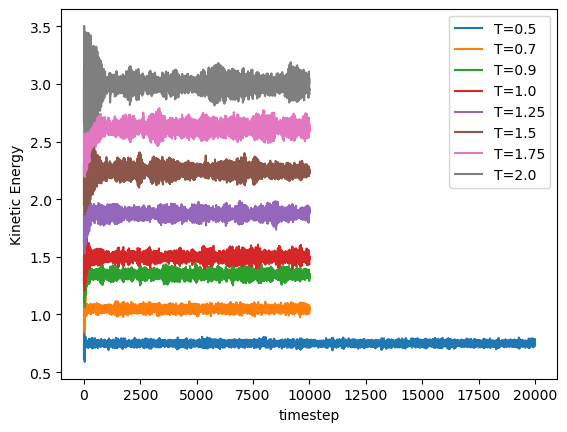

In [180]:
for T, e in ke_temp_runs.items():
  plt.plot(numpy.array(e[:20000])/1728, label=f'T={T}')
plt.xlabel('timestep')
plt.ylabel('Kinetic Energy')
plt.legend()

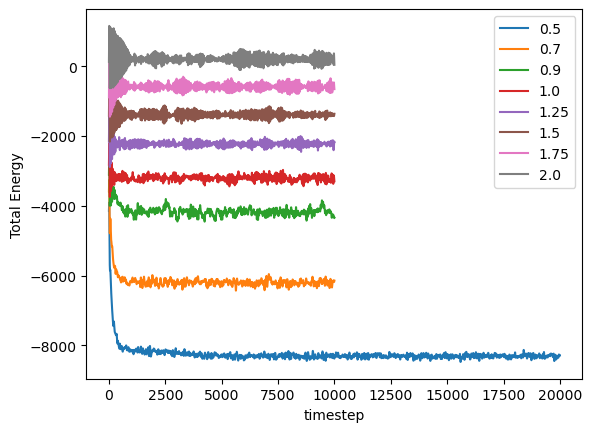

In [183]:
T = [0.5,0.7,0.9,1.0,1.25,1.5,1.75,2.0]
for kT in T:
    total_energy = numpy.array(pe_temp_runs[f"{kT}"])+numpy.array(ke_temp_runs[f"{kT}"])
    plt.plot(total_energy[:20000],label=kT)
plt.xlabel('timestep')
plt.ylabel('Total Energy')
plt.legend()

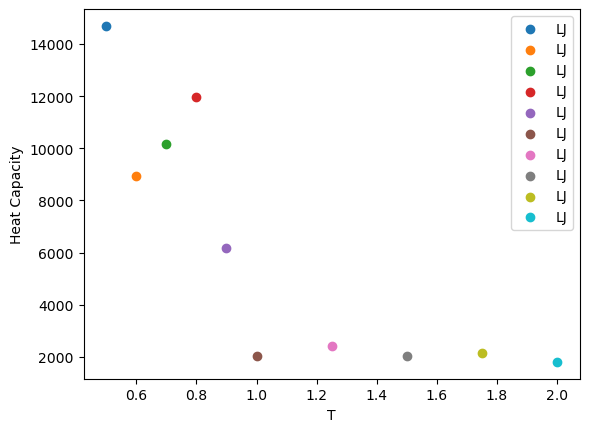

In [127]:
T = [0.5,0.6,0.7,0.8,0.9,1.0,1.25,1.5,1.75,2.0]
for i in T:
    kinetic = []
    potential = []
    time=[]
    traj = gsd.hoomd.open('projectdata/log_T_'+str(i)+'_N_10.gsd', 'r')
    for frame in range(len(traj)):
        kinetic.append(traj[frame].log['md/compute/ThermodynamicQuantities/kinetic_energy'][0])
        potential.append(traj[frame].log['md/compute/ThermodynamicQuantities/potential_energy'][0])
    kinetic_array = numpy.array(kinetic)
    potential_array = numpy.array(potential)
    total_energy = kinetic_array+potential_array
    heatcapacity, error = heat_capacity(energies=total_energy,temp=i)
    plt.scatter(i,heatcapacity,label='LJ')
    plt.errorbar(i,heatcapacity, yerr=error)

plt.xlabel('T')
plt.ylabel('Heat Capacity')
plt.legend()

# Finite Size Effects

In [54]:
N = [5,10,12,20,25,27]
dt = 0.005
T = 0.7
pe_N_runs = {}
ke_N_runs = {}
positions_N = {}
for i in N:
  del simulation
  print(i)
  pe_N_runs[f"{i}"] = []
  ke_N_runs[f"{i}"] = []
  positions_N[f"{i}"] = []
  seed = numpy.random.randint(1,1e4)
  simulation = hoomd.Simulation(device = device, seed = seed)
  simulation.create_state_from_gsd(filename='initial_state_'+str(i)+'.gsd')
  integrator = hoomd.md.Integrator(dt = dt)
  nvt = hoomd.md.methods.NVT(filter = hoomd.filter.All(),kT=T,tau=100*dt)
  integrator.methods.append(nvt)
  cell = hoomd.md.nlist.Cell(buffer=0.4)

  #Define the force for different particles
  lj = hoomd.md.pair.LJ(nlist=cell)

  lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

  lj.r_cut[('A', 'A')] = 2.5*sigma
  integrator.forces.append(lj)
  simulation.operations.integrator = integrator
  simulation.run(10)

  simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=T)
  thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
      filter=hoomd.filter.All()
  )

  simulation.operations.computes.append(thermodynamic_properties)
  logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
  logger.add(simulation)
  logger.add(thermodynamic_properties,quantities=['potential_energy','kinetic_energy','kinetic_temperature','pressure','volume'])
  gsd_writer = hoomd.write.GSD(filename='projectdata/log_finite_T_0.7_N_'+str(i)+'.gsd',
                             trigger=hoomd.trigger.Periodic(1000),
                             mode='xb')
  simulation.operations.writers.append(gsd_writer)
  gsd_writer.log = logger
  tps_tracking = hoomd.logging.Logger(categories=['scalar', 'string'])
  tps_tracking.add(simulation, quantities=['timestep', 'tps'])
  table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e4)), logger=tps_tracking)
  simulation.operations.writers.append(table)
  for step in range(10000):
    simulation.run(10)
    pe_N_runs[f"{i}"].append(thermodynamic_properties.potential_energy)
  ind_samples = 0
  total_steps = 10000
  print(len(pe_N_runs[f"{i}"]))
  while ind_samples < 20:
      a = autocorr1D(pe_N_runs[f"{i}"][500:])
      decorrelation_time = numpy.where(a <= 0)[0][0]
      ind_samples = (total_steps)/decorrelation_time
      print("independent samples: ", ind_samples)
      if ind_samples >= 20:
          break
      for step in range(10000):
        simulation.run(10)
        pe_N_runs[f"{i}"].append(thermodynamic_properties.potential_energy)
      total_steps += 10000
      print(total_steps)
  snapshot = simulation.state.get_snapshot()
  positions_N[f"{i}"].append(snapshot.particles.position)

5
Simulation.timestep  Simulation.tps 
       10000          38626.60944   
       20000          19354.83871   
       30000          19189.76546   
       40000          19148.93617   
       50000          18556.70103   
       60000          42654.02844   
       70000          20408.16327   
       80000          19736.84211   
       90000          20454.54545   
      100000          40358.74439   
10000
independent samples:  121.95121951219512
10
Simulation.timestep  Simulation.tps 
       10000           1751.31349   
       20000           1734.77255   
       30000           1706.48464   
       40000           1744.86235   
       50000           1750.97276   
       60000           1743.51027   
       70000           1704.86835   
       80000           3291.88003   
       90000           3323.48597   
      100000           1703.25511   
10000
independent samples:  10.893246187363834
      110000           1765.74456   
      120000           1716.24714   
      130000 

KeyboardInterrupt: 

-3.844342213501569
-4.542800467737145
-4.634392058459107
-4.926242136982459
-4.992371198850527


Text(0, 0.5, 'avg(PE)/N')

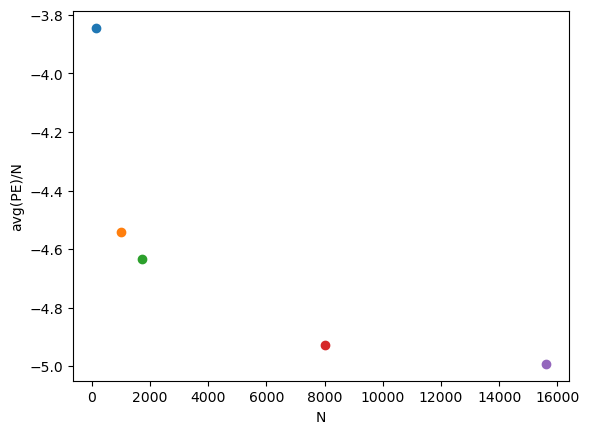

In [55]:
import matplotlib.pyplot as plt
N = [5,10,12,20,25]
for N, e in pe_N_runs.items():
  print(numpy.mean(e[5000:])/(int(N)**3))
  plt.scatter(int(N)**3,numpy.mean(e[5000:])/(int(N)**3))
plt.xlabel('N')
plt.ylabel('avg(PE)/N')

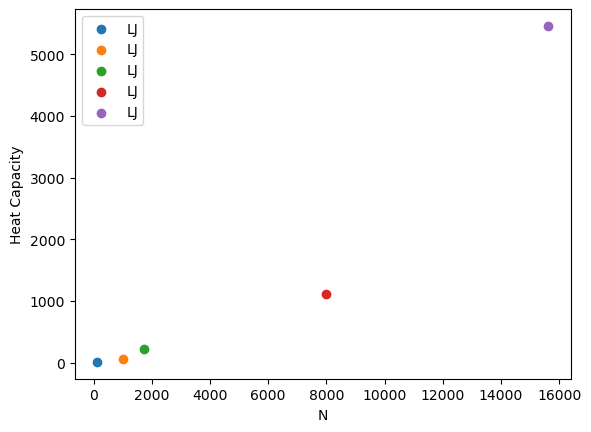

In [130]:
N = [5,10,12,20,25]
for i in N:
    kinetic = []
    potential = []
    time=[]
    traj = gsd.hoomd.open('projectdata/log_finite_T_0.7_N_'+str(i)+'.gsd', 'r')
    for frame in range(len(traj)):
        kinetic.append(traj[frame].log['md/compute/ThermodynamicQuantities/kinetic_energy'][0])
        potential.append(traj[frame].log['md/compute/ThermodynamicQuantities/potential_energy'][0])
    kinetic_array = numpy.array(kinetic)
    potential_array = numpy.array(potential)
    total_energy = kinetic_array+potential_array
    heatcapacity, error = heat_capacity(energies=total_energy,temp=i)
    plt.scatter(i**3,heatcapacity,label='LJ')
    plt.errorbar(i**3,heatcapacity, yerr=error)

plt.xlabel('N')
plt.ylabel('Heat Capacity')
plt.legend()

# Ideal Gas

In [61]:
epsilon=0 #make interactions for LJ forcefield 0 to model an ideal gas
dt = 0.005
T = [0.5,0.8,1.0,1.5,2.0]
pe_ideal_runs = {}
ke_ideal_runs = {}
positions_ideal = {}
for i in T:
  del simulation
  print(i)
  pe_ideal_runs[f"{i}"] = []
  ke_temp_runs[f"{i}"] = []
  positions_ideal[f"{i}"] = []
  seed = numpy.random.randint(1,1e4)
  simulation = hoomd.Simulation(device = device, seed = seed)
  simulation.create_state_from_gsd(filename='initial_state_10.gsd')
  integrator = hoomd.md.Integrator(dt = dt)
  nvt = hoomd.md.methods.NVT(filter = hoomd.filter.All(),kT=i,tau=100*dt)
  integrator.methods.append(nvt)
  cell = hoomd.md.nlist.Cell(buffer=0.4)

  #Define the force for different particles
  lj = hoomd.md.pair.LJ(nlist=cell)

  lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

  lj.r_cut[('A', 'A')] = 2.5*sigma
  integrator.forces.append(lj)
  simulation.operations.integrator = integrator
  simulation.run(10)

  simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=i)
  thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
      filter=hoomd.filter.All()
  )

  simulation.operations.computes.append(thermodynamic_properties)
  logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
  logger.add(simulation)
  logger.add(thermodynamic_properties,quantities=['potential_energy','kinetic_energy','kinetic_temperature','pressure','volume'])
  gsd_writer = hoomd.write.GSD(filename='projectdata/log__ideal_T_'+str(i)+'_N_10.gsd',
                             trigger=hoomd.trigger.Periodic(1000),
                             mode='xb')
  simulation.operations.writers.append(gsd_writer)
  gsd_writer.log = logger
  tps_tracking = hoomd.logging.Logger(categories=['scalar', 'string'])
  tps_tracking.add(simulation, quantities=['timestep', 'tps'])
  table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e4)), logger=tps_tracking)
  simulation.operations.writers.append(table)
  for step in range(10000):
    simulation.run(10)
    pe_ideal_runs[f"{i}"].append(thermodynamic_properties.potential_energy)
  snapshot = simulation.state.get_snapshot()
  positions_ideal[f"{i}"].append(snapshot.particles.position)

0.5
Simulation.timestep  Simulation.tps 
       10000           2249.43764   
       20000           5431.50272   
       30000           2274.45034   
       40000           5924.95063   
       50000           2212.38938   
       60000           5481.12058   
       70000           5703.42205   
       80000           5674.65322   
       90000           5836.57588   
      100000           5481.12058   
0.8
Simulation.timestep  Simulation.tps 
       10000           2188.18381   
       20000           2188.71595   
       30000           2151.56586   
       40000           2174.43827   
       50000           2195.12195   
       60000           5099.15014   
       70000           2170.24355   
       80000           2180.23256   
       90000           2161.90247   
      100000           2199.95111   
1.0
Simulation.timestep  Simulation.tps 
       10000           2190.31394   
       20000           2137.25956   
       30000           2171.29071   
       40000           213

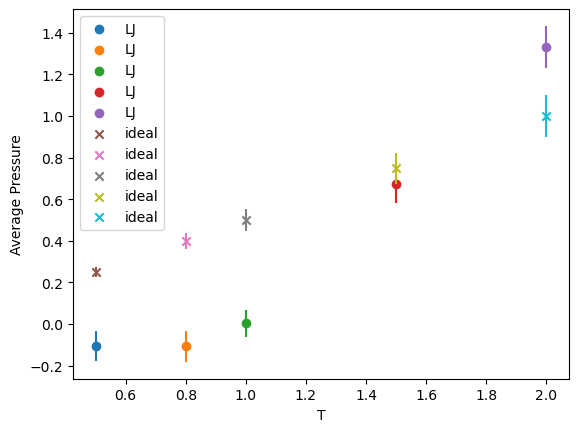

In [100]:
T = [0.5,0.8,1.0,1.5,2.0]
for i in T:
    pressure_LJ = []
    time=[]
    traj = gsd.hoomd.open('projectdata/log_T_'+str(i)+'_N_10.gsd', 'r')
    for frame in range(len(traj)):
        pressure_LJ.append(traj[frame].log['md/compute/ThermodynamicQuantities/pressure'][0])
        time.append(traj[frame].log['Simulation/timestep'][0])        
    plt.scatter(i,numpy.mean(pressure_LJ),label='LJ')
    plt.errorbar(i,numpy.mean(pressure_LJ), yerr=numpy.std(pressure_LJ))
for i in T:
    pressure_ideal = []
    time=[]
    traj = gsd.hoomd.open('projectdata/log__ideal_T_'+str(i)+'_N_10.gsd', 'r')
    for frame in range(len(traj)):
        pressure_ideal.append(traj[frame].log['md/compute/ThermodynamicQuantities/pressure'][0])
        time.append(traj[frame].log['Simulation/timestep'][0])        
    plt.scatter(i,numpy.mean(pressure_ideal),marker='x',label='ideal')
    plt.errorbar(i,numpy.mean(pressure_ideal), yerr=numpy.std(pressure_ideal))

plt.xlabel('T')
plt.ylabel('Average Pressure')
plt.legend()

0.5
0.8
1.0
1.5
2.0


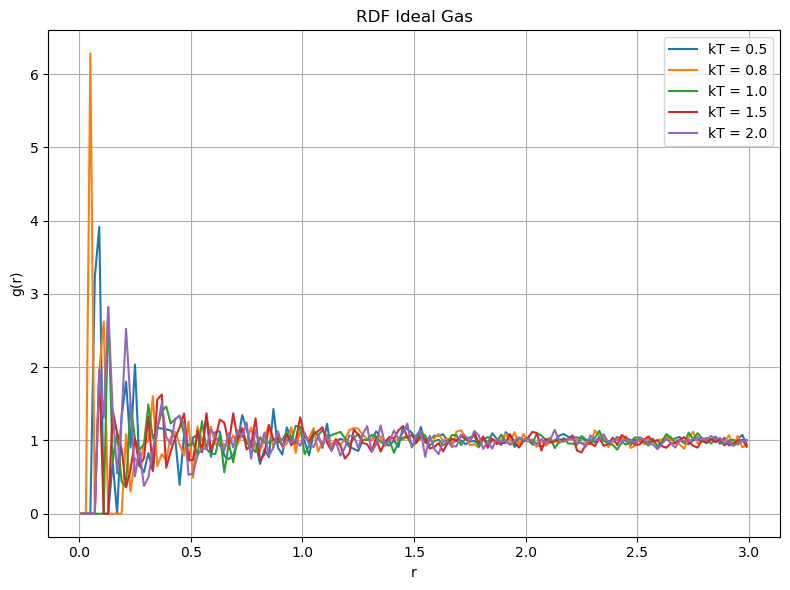

In [63]:
T = [0.5,0.8,1.0,1.5,2.0]
plt.figure(figsize=(8, 6))
for kT in T:
    print(kT)
    snapshot = positions_ideal[f"{kT}"]
    r, g_r = rdf(snapshot[0], density=0.5)
    plt.plot(r,g_r, label=f"kT = {kT}")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.title("RDF Ideal Gas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

30.039145841062822
18.775770899047295
15.348330438196077
10.02343115876202
7.652327623828938


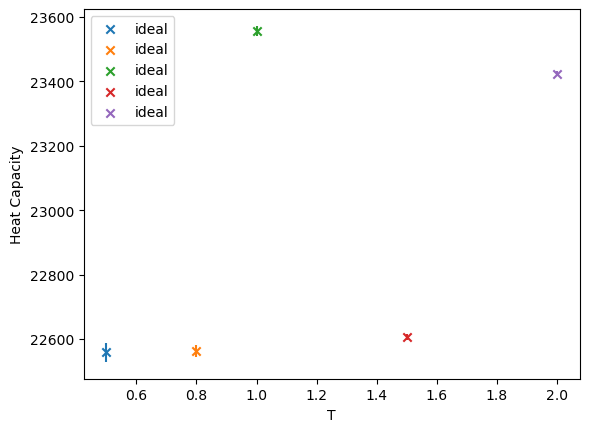

In [122]:
T = [0.5,0.8,1.0,1.5,2.0]
'''for i in T:
    kinetic = []
    potential = []
    time=[]
    traj = gsd.hoomd.open('projectdata/log_T_'+str(i)+'_N_10.gsd', 'r')
    for frame in range(len(traj)):
        kinetic.append(traj[frame].log['md/compute/ThermodynamicQuantities/kinetic_energy'][0])
        potential.append(traj[frame].log['md/compute/ThermodynamicQuantities/potential_energy'][0])
    kinetic_array = numpy.array(kinetic)
    potential_array = numpy.array(potential)
    total_energy = kinetic_array+potential_array
    heatcapacity, error = heat_capacity(energies=total_energy,temp=i)
    plt.scatter(i,heatcapacity,label='LJ')
    plt.errorbar(i,heatcapacity, yerr=error)'''
for i in T:
    kinetic = []
    potential = []
    time=[]
    traj = gsd.hoomd.open('projectdata/log__ideal_T_'+str(i)+'_N_10.gsd', 'r')
    for frame in range(len(traj)):
        kinetic.append(traj[frame].log['md/compute/ThermodynamicQuantities/kinetic_energy'][0])
        potential.append(traj[frame].log['md/compute/ThermodynamicQuantities/potential_energy'][0])
    kinetic_array = numpy.array(kinetic)
    potential_array = numpy.array(potential)
    total_energy = kinetic_array+potential_array
    heatcapacity, error = heat_capacity(energies=total_energy,temp=i)
    print(error)
    plt.scatter(i,heatcapacity,label='ideal',marker = 'x')
    plt.errorbar(i,heatcapacity, yerr=error)
plt.xlabel('T')
plt.ylabel('Heat Capacity')
plt.legend()